# AML flow cytometry analysis

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from fcvae_dataset import load_data
from fcvae_model import VAE, Encoder, Decoder, Classifier
from fcvae_trainer import fcTrainer
from fcvae_plot import CellPlotter2D, plot_joint_aml, plot_shared_markers_aml, plot_imputed_values_set
from umap import UMAP
import flowkit as fk
import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch version:", torch.__version__)
print("Device:", device)

Torch version: 1.2.0
Device: cpu


## 1. Load data

In [2]:
filepath1 = "/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/data_files/"

batch_size = 256         # number of data points in each batch
n_epochs = 20           # times to run the model on complete data
input_dim = 7     # size of each input
hidden_dim = 128        # hidden dimension
latent_dim = 4        # latent vector dimension
lr = 1e-3              # learning rate
n_head = 4
n_shared = 3
missing = 12

datasets = load_data(filepath1)

input_dim_list = []
output_dim_list = []
train_iterators = []
test_iterators = []
train_cells = 0
test_cells = 0
for tube in datasets:
    input_dim_list.append(len(tube[0].columns))
    output_dim_list.append(len(tube[0].columns)+missing)
    train_iterators.append(tube[3])
    test_iterators.append(tube[4])
    train_cells += tube[1].nb_cells
    test_cells += tube[2].nb_cells

N_train = int(train_cells/n_head)
N_test = int(test_cells/n_head)
print('Training set size:', N_train)
print('Test set size:', N_test)

Training set size: 27000
Test set size: 3000


## 2. Create a model

In [3]:
# Encoder
encoder = Encoder(n_head, input_dim_list, hidden_dim, latent_dim)

# Decoder
decoder = Decoder(latent_dim, hidden_dim, output_dim_list, n_head)

# VAE
model = VAE(encoder, decoder).to(device)

# Discriminator
discriminator = Classifier(latent_dim, hidden_dim, n_head) 

print("n_tubes:", n_head)
print("n_shared:", n_shared)
print("n_other:", missing)
print("output_dim:", output_dim_list[0])
print("encoder_dims:", input_dim_list)

n_tubes: 4
n_shared: 3
n_other: 12
output_dim: 19
encoder_dims: [7, 7, 7, 7]


## 3. Train the model

In [9]:
# Create trainer
trainer = fcTrainer(
            model,
            discriminator,
            train_loaders = train_iterators,
            test_loaders = test_iterators,
            N_train = N_train,
            N_test = N_test,
            dloss_weight = 10,
            device = device,
            n_epochs = n_epochs,
            print_frequency = 1,
            optimizer_kwargs = dict(lr = lr)
)

05/03/2020 14:48:30 [INFO]: Creating a trainer on device `cpu`


In [10]:
# Run training
trainer.train()

05/03/2020 14:48:33 [INFO]: TRAINING STARTED (n_epochs = 20).
05/03/2020 14:49:08 [INFO]: Epoch: 00, VAE loss: (53.20657, 44.46269), Discriminator loss: (3.31295, 4.27546)
05/03/2020 14:49:39 [INFO]: Epoch: 01, VAE loss: (52.69901, 43.99943), Discriminator loss: (3.26017, 4.19875)
05/03/2020 14:50:07 [INFO]: Epoch: 02, VAE loss: (52.34696, 42.57387), Discriminator loss: (3.20418, 4.24588)
05/03/2020 14:50:35 [INFO]: Epoch: 03, VAE loss: (51.90884, 45.77794), Discriminator loss: (3.17274, 4.18114)
05/03/2020 14:51:04 [INFO]: Epoch: 04, VAE loss: (51.36203, 44.83974), Discriminator loss: (3.13208, 4.19193)
05/03/2020 14:51:32 [INFO]: Epoch: 05, VAE loss: (51.26692, 41.74095), Discriminator loss: (3.17565, 4.24999)
05/03/2020 14:52:00 [INFO]: Epoch: 06, VAE loss: (51.18508, 46.67385), Discriminator loss: (3.1425, 4.18622)
05/03/2020 14:52:29 [INFO]: Epoch: 07, VAE loss: (50.50896, 44.47877), Discriminator loss: (3.10196, 4.26414)
05/03/2020 14:52:58 [INFO]: Epoch: 08, VAE loss: (50.30084,

## 4. Visualization

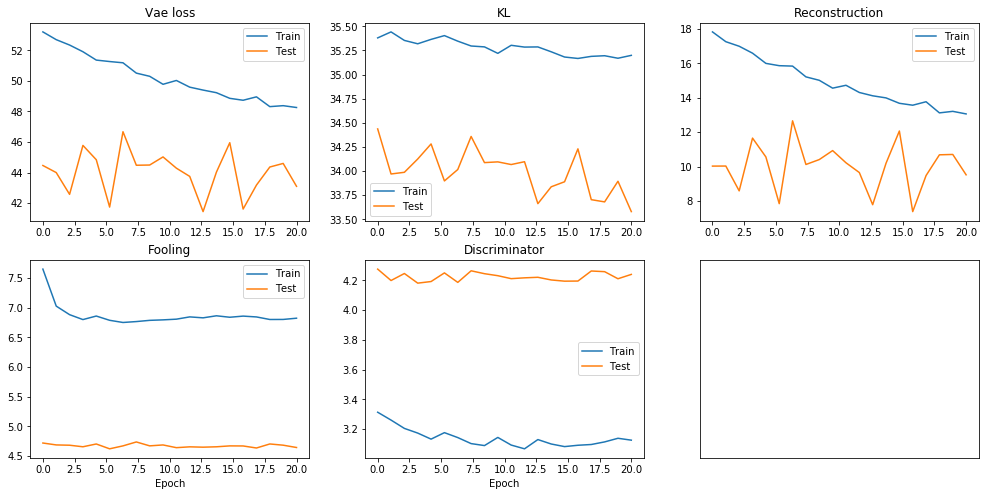

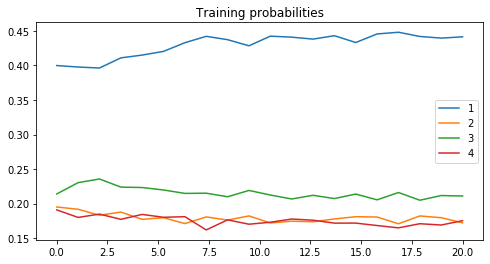

In [11]:
trainer.plot()
trainer.plot_probs()

/home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


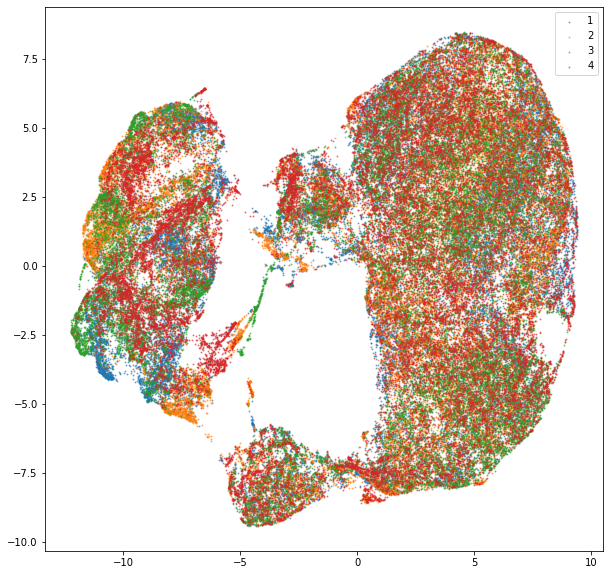

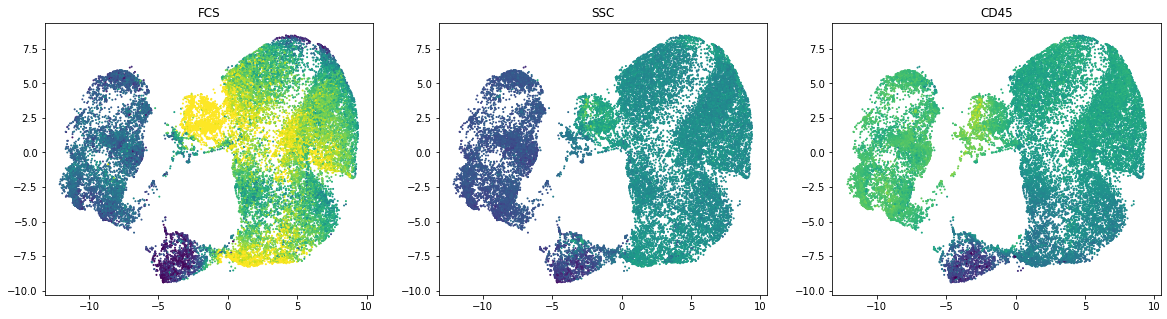

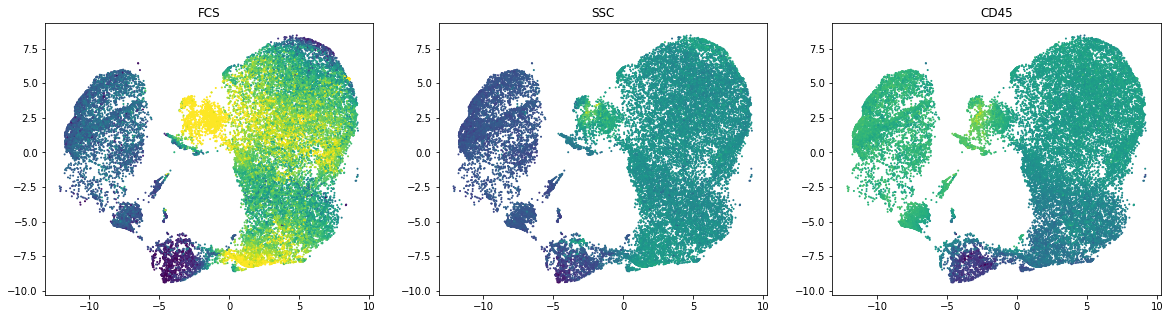

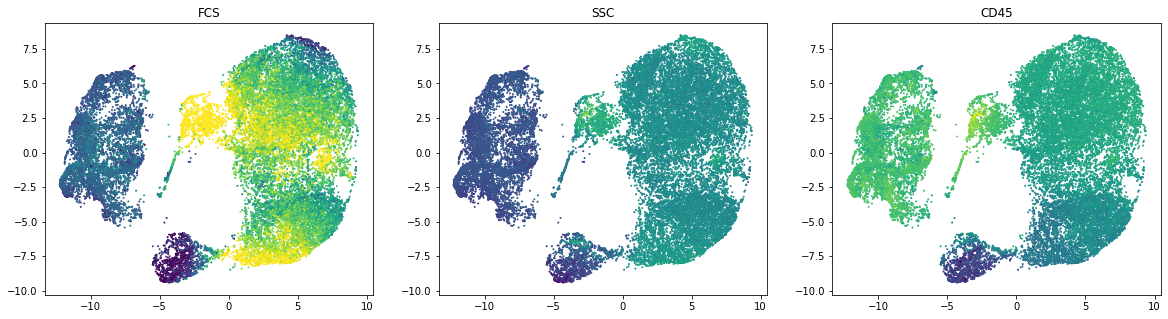

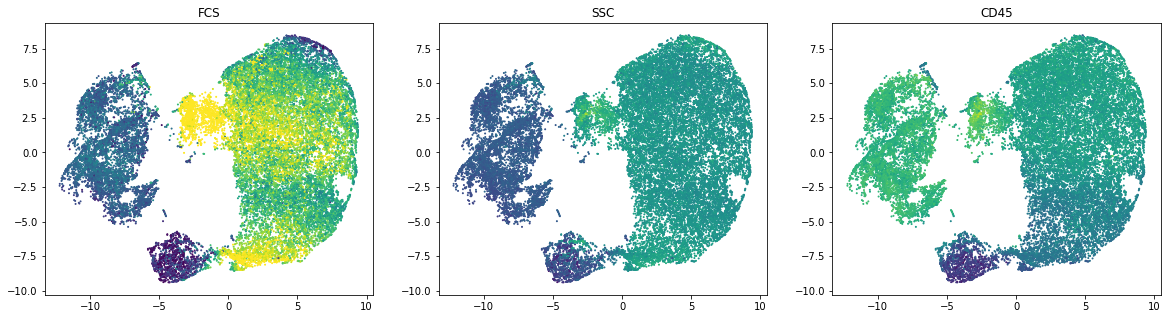

In [12]:
latents = []

trainer.vae.eval()
for i in range(n_head):
    data = Variable(torch.from_numpy(datasets[i][0].to_numpy()), requires_grad=False)
    latents.append(model.get_z(data.float(), i).data.numpy())
latent2d = UMAP().fit_transform(np.concatenate(latents))

plot_joint_aml(trainer, latent2d, latents)
plot_shared_markers_aml(trainer, latent2d, latents, datasets)

## 5. Imputation

/home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/flowio/flowdata.py:275: UserWarning: text in segment does not start and end with delimiter
  warn("text in segment does not start and end with delimiter")


[['CD15-FITC', 'CD13-PE', 'CD16-PC5', 'CD56-PC7'], ['CD5-FITC', 'CD19-PE', 'CD3-PC5', 'CD10-PC7'], ['CD14-FITC', 'CD11c-PE', 'CD64-PC5', 'CD33-PC7'], ['HLA-DR-FITC', 'CD117-PE', 'CD34-PC5', 'CD38-PC7']]


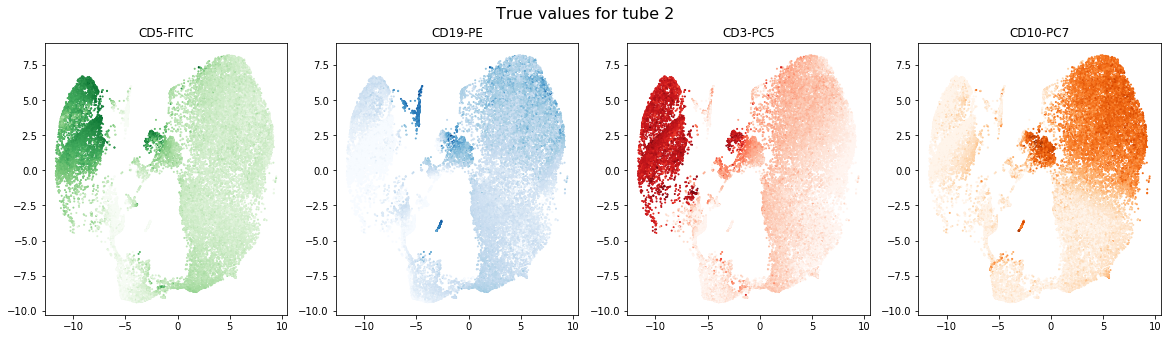

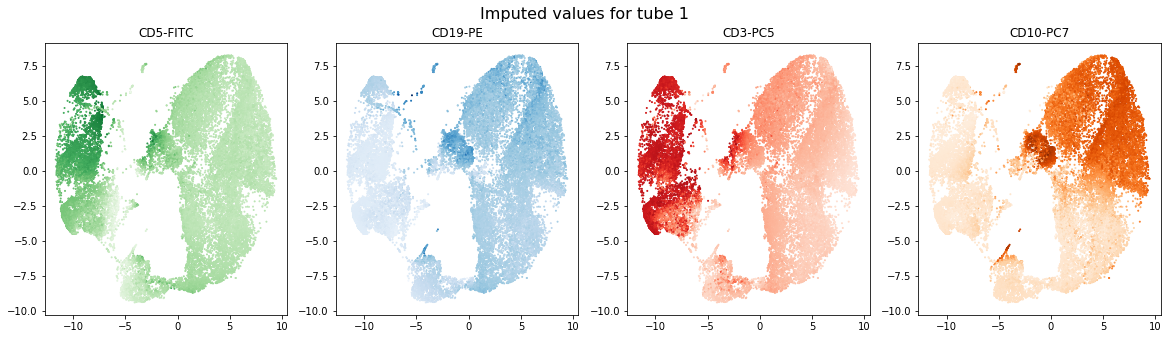

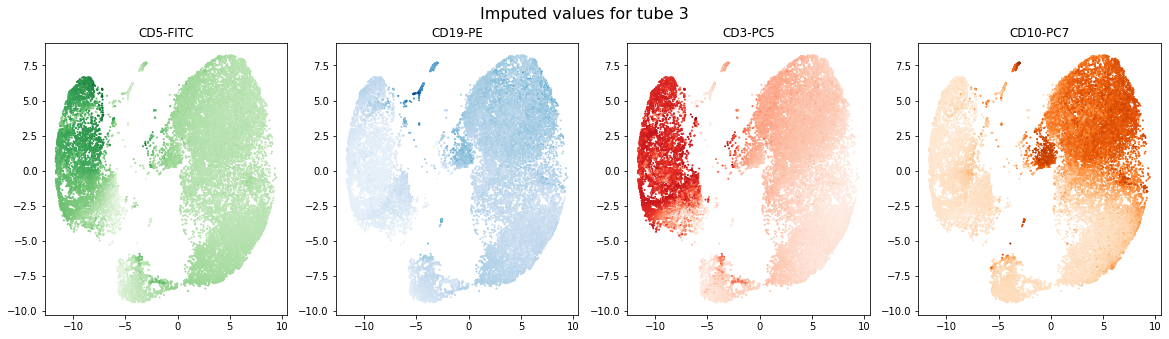

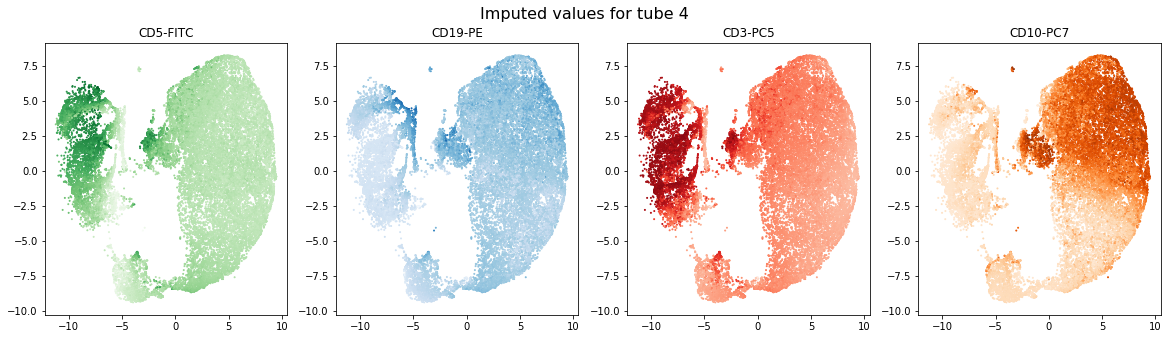

In [8]:
# marker names 
files = glob.glob(filepath1 + "*.txt")
titles = []
for i in range(len(files)):
    fcs = files[i][-8:-4]
    fcs_path = '/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/Data/AML/FCS/'+fcs+'.FCS'
    sample = fk.Sample(fcs_path, subsample_count=None)
    features = sample.pns_labels[2:7]
    features.pop(2)
    titles.append(features)
print(titles) 

# visualize one set of imputed values, change later
#plot_imputed_values(trainer, latent2d, latents, datasets, titles)
tube_id = 1
plot_imputed_values_set(trainer, tube_id, latent2d, latents, datasets, titles[tube_id])

## 6. Validation metrics

In [17]:
# Comparison: accuracy and log p(y)?

def validation_accuracy(model, discriminator, test_iterators):
    model.eval()
    discriminator.eval()
    probs = []
    for tensors in test_iterators:
        ps = []
        for head_id, batch in enumerate(tensors):
            z = model.get_z(batch.float(), head_id)
            p = discriminator.classify(z)
            ps.append(p)
        pr = torch.cat(ps).cpu().detach().numpy()
        probs.append(pr)
    return probs

def validation_loss(test_iterators, model, input_dim_list):
    # set the evaluation mode
    model.eval()
    n_head = len(input_dim_list)
    # test loss for the data
    test_losses = []
    
    for tensors in test_iterators:
        for head_id, x in enumerate(tensors): 
            # reshape the data
            x = x.view(-1, input_dim_list[head_id]) 
            x = x.float()
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x, head_id)

            loss, recs, kls = model.loss(x_sample, x, z_mu, z_var, head_id)
            test_losses.append(loss)
    sum_loss = torch.stack(test_losses).sum()

    return sum_loss

runs = 5
accuracies = []
val_losses = []
for i in range(runs):
    trainer.train()
    acc = validation_accuracy(model, discriminator, zip(*test_iterators))
    acc = [item for sublist in acc for item in sublist]
    acc = [item for sublist in acc for item in sublist]
    print(len(acc))
    correct = 0
    probs1 = acc[::n_head]
    for i in probs1[:N_test]:
        if i > 1/n_head:
            correct += 1
    for i in probs1[N_test:]:
        if i < 1/n_head:
            correct += 1

accuracy = correct/len(acc[::4])
accuracies.append(accuracy)
val_loss = validation_loss(zip(*test_iterators), model, input_dim_list)/N_test
val_losses.append(val_loss)
print(accuracies)
print(val_losses)

48000
[0.49066666666666664]
[tensor(43.0996, grad_fn=<DivBackward0>)]


In [6]:
print(np.mean(accuracies))
print(torch.mean(torch.stack(val_losses)))

0.5005666666666667
tensor(13.6274, grad_fn=<MeanBackward0>)
